In [55]:
using Revise
using MajoranaPropagation
using PauliPropagation

using Plots
using LaTeXStrings
using TimerOutputs
using ProgressMeter

Simulate the dynamics of the spinful Hubbard model on a 1D chain of $N$ spinful sites. The Hamiltonian is
$$\hat{H}=-t \sum_{i, \sigma=\{\uparrow, \downarrow\}}\left(\hat{c}_{i, \sigma}^{\dagger} \hat{c}_{i+1, \sigma}+\hat{c}_{i+1, \sigma}^{\dagger} \hat{c}_{i, \sigma}\right)+U \sum_i \hat{n}_{i \uparrow} \hat{n}_{i \downarrow}$$

In [56]:
N_spinful_sites = 20
t = 1.
U = 1.5

n_layers = 10
dt = 0.07

0.07

Get 1D connectivity, and create the circtuit for implementing a single layer of first order Trotterization.

In [57]:
topo = bricklayertopology(N_spinful_sites)

circ_single = []
thetas_single = []

#up hoppings 
for (i, j) in topo
    push!(circ_single, FermionicGate(:hopup, [i, j], N_spinful_sites))
    push!(thetas_single, -t * dt)
end

#down hoppings 
for (i, j) in topo
    push!(circ_single, FermionicGate(:hopdn, [i, j], N_spinful_sites))
    push!(thetas_single, -t * dt)
end

#on-site repulsion 
for i = 1:N_spinful_sites
    push!(circ_single, FermionicGate(:nupndn, i, N_spinful_sites))
    push!(thetas_single, U * dt)
end

#### Set the truncations
1. `min_abs_coeff`: PP coefficient truncation
2. `max_singles`: number of unpaired Majoranas, namely the number of indices $i$ where only one of $\gamma_i$, $\gamma'_i$ are non-zero

In [58]:
min_abs_coeff = 1.e-7
max_singles = 10

max_single_filter = create_max_single_filter(2 * N_spinful_sites)
custom_trunc = let max_single_filter = max_single_filter, max_singles = max_singles
    (mstr, coeff) -> (compute_max_single(mstr, 0, max_single_filter) > max_singles)
end

#23 (generic function with 1 method)

Set the inital state as the checkerboard state $\ket{\uparrow\downarrow\cdots\uparrow\downarrow}$

In [59]:
#initial state 
initial_state_label = "Checkerboard"

create_up_part_at = []
create_down_part_at = []

for j = 1:N_spinful_sites
    if j % 2 == 1
        push!(create_up_part_at, j)
    else
        push!(create_down_part_at, j)
    end
end

Backpropagate $n_{2,\uparrow}$, the up density on site 2

In [60]:
to = TimerOutput()

site_index = 3
obs = MajoranaSum(N_spinful_sites, :nup, site_index)

@show obs

res = zeros(n_layers + 1)
res[1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites)

@showprogress for k = 1:n_layers
    @timeit to "propagate" propagate!(circ_single, obs, thetas_single, min_abs_coeff=min_abs_coeff, customtruncfunc=custom_trunc)
    @timeit to "evaluate" res[k+1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites)
end

to

obs = MajoranaSum with 2 term(s):(
    0.5 * 00000000000000000000000000000000000000000000000000000000000000000000000000000000
    0.5 * 00000000110000000000000000000000000000000000000000000000000000000000000000000000)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


──────────────────────────────────────────────────────────────────────
                             Time                    Allocations      
                    ───────────────────────   ────────────────────────
 Tot / % measured:       971ms /  97.7%           56.3MiB /  98.7%    

Section     ncalls     time    %tot     avg     alloc    %tot      avg
──────────────────────────────────────────────────────────────────────
propagate       10    941ms   99.2%  94.1ms   39.8MiB   71.5%  3.98MiB
evaluate        10   7.37ms    0.8%   737μs   15.8MiB   28.5%  1.58MiB
──────────────────────────────────────────────────────────────────────

If desired, you can benchmark the MP results with an ITensor implementation of the same circuits used in `propagate!`.

In [61]:
do_mps = false

if do_mps
    _, _, mps_circ_single, mps_thetas_single = hubbard_circ_fermionic_sites(topo, N_spinful_sites, 1, t, U, dt; return_mps_instructions=true)
    include("mps_codes.jl")
    mps_obs = "N"
    #index for an "up" density
    mps_index = 2 * site_index - 1
    χ = 100

    mps_initial_state = []
    for uppart in create_up_part_at
        push!(mps_initial_state, 2 * uppart - 1)
    end
    for downpart in create_down_part_at
        push!(mps_initial_state, 2 * downpart)
    end

    res_mps = zeros(n_layers + 1)
    res_mps[1] = run_circ_mps(2 * N_spinful_sites, [], mps_initial_state, [], mps_obs; χ=χ)[mps_index]

    for k = 1:n_layers
        mps_circ = repeat(mps_circ_single, k)
        mps_thetas = repeat(mps_thetas_single, k)
        res_mps[k+1] = run_circ_mps(2 * N_spinful_sites, mps_circ, mps_initial_state, mps_thetas, mps_obs; χ=χ)[mps_index]
    end
    println("Difference with MP: ", res .- res_mps)
end

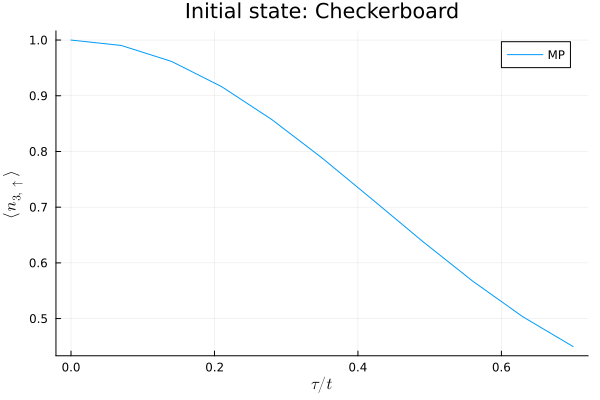

In [62]:
p = plot(dt * (0:n_layers) ./ t, res, label="MP", xlabel=L"\tau/t", ylabel=L"\langle n_{%$site_index,\uparrow}\rangle", title="Initial state: " * initial_state_label)
if do_mps
    plot!(p, dt * (0:n_layers) ./ t, res_mps, label="mps", color=:black, linestyle=:dash)
end
display(p)